In [29]:
import numpy as np
import glob 
# load identities from an npz file with images
for file in glob.glob("/Users/tristan/Downloads/luminance/data/group_1_*_single*.npz"):
    with np.load(file) as data:
        print(data.files)
        print(data["tracklets"].shape)
        print(data["images"].shape)
        print(np.unique(data["frame_segment_indexes"]))

        # find consecutive streaks of frame segments
        images = []
        tracklets = []
        frames = []

        for segment in np.unique(data["frame_segment_indexes"]):
            indices = np.where(data["frame_segment_indexes"] == segment)[0]
            streaks = np.split(indices, np.where(np.diff(indices) != 1)[0] + 1)
            for streak in streaks:
                if(len(streak) > 5):
                    tracklet = [
                        data["frames"][streak[0]],
                        data["frames"][streak[-1]]
                    ]
                    # print the segment and the length of the streak
                    print(f"Segment {segment} {tracklet}: {len(streak)} consecutive images")
                    #
                    # images.append(data["images"][streak])
                    frameNrs = data["frames"][streak]
                    i = data["ids"][streak]
                    assert np.unique(i).size == 1, "Streaks should have the same id"
                    tracklet.append(i[0])
                    tracklets.append(tracklet)
                    images.append(data["images"][streak])
                    frames.append(data["frames"][streak])


['images', 'dimensions', 'positions', 'frame_segment_indexes', 'tracklets', 'frames', 'ids', 'encoding']
(214, 2)
(192490, 80, 80, 1)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 21

In [34]:
# Now we have all the tracklets
tracklets = np.array(tracklets, dtype=int)
print(f"Found {len(tracklets)} tracklets")

# find all overlapping tracklets + ids + images
overlapping = []
for i in range(len(tracklets)):
    for j in range(i + 1, len(tracklets)):
        if np.intersect1d(tracklets[i][0], tracklets[j][0]).size > 0:
            overlapping.append((i, j))
print(f"Found {len(overlapping)} overlapping tracklets")

Found 184 tracklets
Found 136 overlapping tracklets


In [85]:
# from all single tracklets find sequences of N images sampled from the tracklet
def sample_tracklet_images(images, n):
    """
    Sample N images from a tracklet.
    """
    if len(images) < n:
        return images
    else:
        return images[np.random.choice(images.shape[0], n, replace=False)]

# from all overlapping tracklets find sequences of N-1 images sampled from one of them (randomly) and one from the other in last place
def sample_overlapping_tracklets(overlapping, images, n):
    """
    Sample N images from all overlapping tracklets.
    """
    i, j = overlapping
    return np.array(list(sample_tracklet_images(images[i], n - 1)) 
                    + list(sample_tracklet_images(images[j], 1)))

#sample_tracklet_images(tracklets[0], images[0], 5).shape
#sample_overlapping_tracklets(overlapping[0], tracklets, images, 5).shape


(32, 5, 80, 80, 1)
(32, 5, 1, 80, 80)
torch.Size([32, 5, 1, 80, 80]) torch.float32


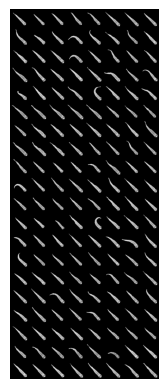

torch.Size([32, 5, 1, 80, 80]) torch.float32


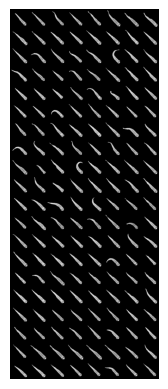

torch.Size([32, 5, 1, 80, 80]) torch.float32


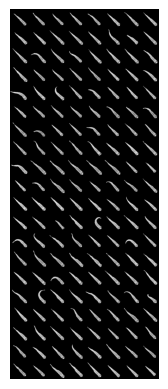

torch.Size([32, 5, 1, 80, 80]) torch.float32


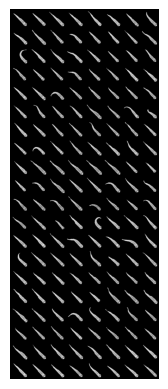

torch.Size([32, 5, 1, 80, 80]) torch.float32


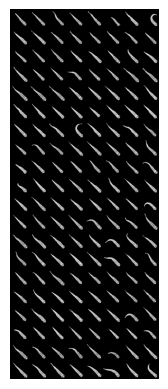

torch.Size([32, 5, 1, 80, 80]) torch.float32


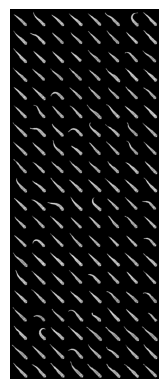

torch.Size([32, 5, 1, 80, 80]) torch.float32


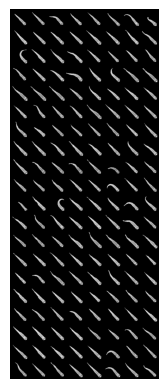

torch.Size([32, 5, 1, 80, 80]) torch.float32


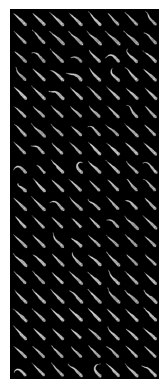

torch.Size([32, 5, 1, 80, 80]) torch.float32


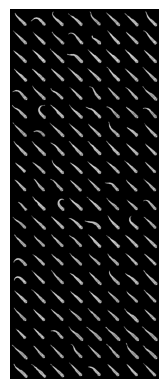

torch.Size([32, 5, 1, 80, 80]) torch.float32


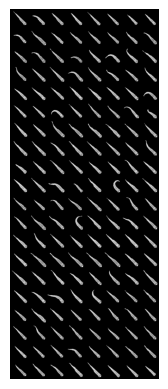

In [86]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def create_dataloader(tracklets, images, n, batch_size):
    """
    Create a DataLoader for the tracklets.
    """
    # select N random tracklets
    selected_tracklets = np.random.choice(np.arange(len(tracklets)), size=batch_size // 2, replace=False)
    dataset = np.array([sample_tracklet_images(images[tracklet], n) for tracklet in selected_tracklets]).astype(np.float32)

    selected_tracklets = np.random.choice(np.arange(len(tracklets)), size=batch_size - len(selected_tracklets), replace=False)
    overlapping_tracklets = np.array([sample_overlapping_tracklets(overlapping[np.random.choice(len(overlapping))], images, n) for _ in selected_tracklets]).astype(np.float32)
    dataset = np.concatenate((dataset, overlapping_tracklets), axis=0)

    # reshuffle batch
    np.random.shuffle(dataset)

    # move channels from channels_last to default
    print(dataset.shape)
    dataset = dataset.transpose((0, 1, 4, 2, 3))
    print(dataset.shape)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = create_dataloader(tracklets, images, 5, batch_size = 32)
for i in range(10):
    batch = next(iter(dataset))
    print(batch.shape, batch.dtype)  # Should print (batch_size, n, image_height, image_width, channels)
    # Here you can add code to visualize or process the batch further

    # plot the images in the batch
    grid = make_grid(batch.view(-1, 1, 80, 80), nrow=8, normalize=True)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

In [8]:
# reid_npz_dataset.py
import glob
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional, Callable, Dict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


# -------------------------------
# Tracklet container
# -------------------------------
@dataclass
class Tracklet:
    idx: int
    start_frame: int
    end_frame: int
    identity: int
    images: np.ndarray   # (T,H,W[,C]) channels-last
    frames: np.ndarray   # (T,)


# -------------------------------
# NPZ → tracklets
# -------------------------------
def _to_uint1(x: np.ndarray) -> np.ndarray:
    # 1) remove NaN/Inf early (before any max/scale ops)
    x = np.nan_to_num(x, nan=0.0, posinf=255.0, neginf=0.0).astype(np.float32, copy=False)
    # 2) heuristic scale
    scale = 255.0 if x.max() > 1.5 else 1.0
    x = x / scale
    # 3) final clamp
    return np.clip(x, 0.0, 1.0)

def _extract_tracklets_from_npz(npz_path: str, min_streak_len: int) -> List[Tracklet]:
    out: List[Tracklet] = []
    with np.load(npz_path) as data:
        segs   = np.asarray(data["frame_segment_indexes"])
        frames = np.asarray(data["frames"])
        ids    = np.asarray(data["ids"])
        imgs   = np.asarray(data["images"])  # (N,H,W[,C])

        assert len(segs) == len(frames) == len(ids) == len(imgs), "NPZ arrays mismatch"

        for segment in np.unique(segs):
            idxs = np.where(segs == segment)[0]
            cuts = np.where(np.diff(idxs) != 1)[0] + 1
            streaks = np.split(idxs, cuts)

            for st in streaks:
                if len(st) < min_streak_len:
                    continue
                sid = ids[st]
                if np.unique(sid).size != 1:
                    continue  # skip mixed-ID streaks

                t_frames = frames[st]
                t_imgs   = imgs[st]
                out.append(Tracklet(
                    idx=-1,
                    start_frame=int(t_frames[0]),
                    end_frame=int(t_frames[-1]),
                    identity=int(sid[0]),
                    images=t_imgs,
                    frames=t_frames,
                ))
    return out

def load_tracklets(files_glob: str, min_streak_len: int = 6) -> List[Tracklet]:
    tracklets: List[Tracklet] = []
    for p in glob.glob(files_glob):
        tracklets.extend(_extract_tracklets_from_npz(p, min_streak_len))
    for i, tr in enumerate(tracklets):
        tr.idx = i
    if not tracklets:
        raise RuntimeError(f"No tracklets found for: {files_glob}")
    return tracklets


# -------------------------------
# Splitting
# -------------------------------
def split_by_identity(tracklets: List[Tracklet], val_fraction: float = 0.2, seed: int = 1337):
    """Make sure identities don’t leak across splits."""
    rng = random.Random(seed)
    ids = sorted({t.identity for t in tracklets})
    rng.shuffle(ids)
    n_val = max(1, int(round(len(ids) * val_fraction)))
    val_ids = set(ids[:n_val])
    train = [t for t in tracklets if t.identity not in val_ids]
    val   = [t for t in tracklets if t.identity in  val_ids]
    for i, t in enumerate(train): t.idx = i
    for i, t in enumerate(val):   t.idx = i
    return train, val, val_ids


# -------------------------------
# Overlaps (for hard negatives)
# -------------------------------
def _intervals_overlap(a0: int, a1: int, b0: int, b1: int) -> bool:
    return max(a0, b0) <= min(a1, b1)

def build_overlapping_pairs(tracklets: List[Tracklet]) -> List[Tuple[int, int]]:
    pairs = []
    for i, ti in enumerate(tracklets):
        for j in range(i + 1, len(tracklets)):
            tj = tracklets[j]
            if ti.identity == tj.identity:
                continue
            if _intervals_overlap(ti.start_frame, ti.end_frame, tj.start_frame, tj.end_frame):
                pairs.append((i, j))
    return pairs


# -------------------------------
# Sampling helpers
# -------------------------------
def _sample_indices(T: int, n: int, replace_ok: bool = True) -> np.ndarray:
    if T >= n:
        return np.random.choice(T, n, replace=False)
    return np.random.choice(T, n, replace=replace_ok)

def _ensure_chw3(x: np.ndarray) -> np.ndarray:
    x = _to_uint1(x)
    if x.ndim == 2:
        x = x[..., None]
    if x.shape[-1] == 1:
        x = np.repeat(x, 3, axis=-1)
    if x.shape[-1] != 3:
        raise ValueError(f"Unsupported channels: {x.shape}")
    return np.transpose(x, (2, 0, 1)).astype(np.float32, copy=False)

def _stack_keys(imgs: np.ndarray, idxs: np.ndarray) -> torch.Tensor:
    xs = [_ensure_chw3(imgs[i]) for i in idxs]
    arr = np.stack(xs, axis=0)  # (S,3,H,W)
    return torch.from_numpy(arr)


# -------------------------------
# Dataset
# -------------------------------
class ReIDTrackletDataset(Dataset):
    """
    Yields a dict:
      keys         : (S,3,H,W) float32
      key_lengths  : int (S)
      query        : (3,H,W) float32
      label        : float32 in {0.,1.}
    """
    def __init__(
        self,
        tracklets: List[Tracklet],
        n_keys_min: int = 4,
        n_keys_max: Optional[int] = None,
        positive_fraction: float = 0.5,
        num_samples: int = 10_000,
        key_transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
        query_transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
        seed: Optional[int] = None,
    ):
        super().__init__()
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        self.tracklets = tracklets
        self.n_keys_min = int(n_keys_min)
        self.n_keys_max = int(n_keys_min if n_keys_max is None else n_keys_max)
        self.positive_fraction = float(positive_fraction)
        self.num_samples = int(num_samples)
        self.key_tf = key_transform
        self.query_tf = query_transform

        # per-dataset overlaps & id index (don’t cross splits)
        self.overlaps = build_overlapping_pairs(self.tracklets)
        self.by_id: Dict[int, List[int]] = {}
        for tr in self.tracklets:
            self.by_id.setdefault(tr.identity, []).append(tr.idx)
        self.all_ids = sorted(self.by_id.keys())

    def __len__(self):
        return self.num_samples

    def _sample_S(self) -> int:
        if self.n_keys_min == self.n_keys_max:
            return self.n_keys_min
        return random.randint(self.n_keys_min, self.n_keys_max)

    def _sample_positive(self, S: int):
        tr = random.choice(self.tracklets)
        T = tr.images.shape[0]
        key_idx = _sample_indices(T, S, replace_ok=True)
        keys = _stack_keys(tr.images, key_idx)
        # query from same tracklet (prefer not reusing a key index)
        remaining = np.setdiff1d(np.arange(T), key_idx)
        q_idx = np.random.choice(remaining if remaining.size > 0 else np.arange(T))
        query = torch.from_numpy(_ensure_chw3(tr.images[q_idx]))

        if self.key_tf:   keys  = torch.stack([self.key_tf(k) for k in keys], dim=0)
        if self.query_tf: query = self.query_tf(query)

        return {
            "keys": keys,
            "key_lengths": S,
            "query": query,
            "label": torch.tensor(1.0, dtype=torch.float32),
        }

    def _sample_negative(self, S: int):
        if self.overlaps:
            i, j = random.choice(self.overlaps)
            if random.random() < 0.5:
                tr_keys, tr_q = self.tracklets[i], self.tracklets[j]
            else:
                tr_keys, tr_q = self.tracklets[j], self.tracklets[i]
        else:
            # Fallback: sample two different identities
            if len(self.all_ids) < 2:
                return self._sample_positive(S)
            id_a, id_b = random.sample(self.all_ids, 2)
            tr_keys = self.tracklets[random.choice(self.by_id[id_a])]
            tr_q    = self.tracklets[random.choice(self.by_id[id_b])]

        T_a = tr_keys.images.shape[0]
        key_idx = _sample_indices(T_a, S, replace_ok=True)
        keys = _stack_keys(tr_keys.images, key_idx)

        T_b = tr_q.images.shape[0]
        q_idx = np.random.choice(T_b)
        query = torch.from_numpy(_ensure_chw3(tr_q.images[q_idx]))

        if self.key_tf:   keys  = torch.stack([self.key_tf(k) for k in keys], dim=0)
        if self.query_tf: query = self.query_tf(query)

        return {
            "keys": keys,
            "key_lengths": S,
            "query": query,
            "label": torch.tensor(0.0, dtype=torch.float32),
        }

    def __getitem__(self, idx: int):
        S = self._sample_S()
        if random.random() < self.positive_fraction:
            return self._sample_positive(S)
        else:
            return self._sample_negative(S)


# -------------------------------
# Collate (pads in time)
# -------------------------------
def collate_reid(batch: List[dict]) -> dict:
    B = len(batch)
    S_max = max(sample["key_lengths"] for sample in batch)
    C, H, W = batch[0]["query"].shape

    keys_out = torch.zeros(B, S_max, C, H, W, dtype=torch.float32)
    key_lengths = torch.zeros(B, dtype=torch.int64)
    queries = torch.zeros(B, C, H, W, dtype=torch.float32)
    labels = torch.zeros(B, dtype=torch.float32)

    for i, sample in enumerate(batch):
        S = sample["key_lengths"]
        key_lengths[i] = S
        keys_out[i, :S] = sample["keys"]
        queries[i] = sample["query"]
        labels[i] = sample["label"]

    return [keys_out, key_lengths, queries, labels]


# -------------------------------
# Convenience: make loaders
# -------------------------------
def make_loaders(
    train_tracklets: List[Tracklet],
    val_tracklets: List[Tracklet],
    *,
    batch_size: int = 32,
    n_keys_min: int = 4,
    n_keys_max: Optional[int] = None,
    train_samples: int = 20_000,
    val_samples: int = 2_000,
    positive_fraction_train: float = 0.5,
    positive_fraction_val: float = 0.5,
    num_workers: int = 0,
    pin_memory: bool = False,
):
    train_ds = ReIDTrackletDataset(
        train_tracklets,
        n_keys_min=n_keys_min,
        n_keys_max=n_keys_max,
        positive_fraction=positive_fraction_train,
        num_samples=train_samples,
        seed=None,
    )
    val_ds = ReIDTrackletDataset(
        val_tracklets,
        n_keys_min=n_keys_min,
        n_keys_max=n_keys_max,
        positive_fraction=positive_fraction_val,
        num_samples=val_samples,
        seed=1234,  # deterministic-ish validation sampling
    )
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, drop_last=True,
        num_workers=num_workers, pin_memory=pin_memory, collate_fn=collate_reid
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False,
        num_workers=num_workers, pin_memory=pin_memory, collate_fn=collate_reid
    )
    return train_loader, val_loader

In [25]:
# train_reid.py (or your notebook cell)

import torch

FILES = "/Users/tristan/Downloads/luminance/data/*group_1_*_single*.npz"

# 1) Load and split by identity
all_tracklets = load_tracklets(FILES, min_streak_len=6)
train_tr, val_tr, val_ids = split_by_identity(all_tracklets, val_fraction=0.2, seed=1337)
print(f"Tracklets: train={len(train_tr)}  val={len(val_tr)}  (val IDs: {len(val_ids)}) (train IDs: {len(set(t.identity for t in train_tr))})")

# 2) macOS/MPS-safe DataLoader settings
use_mps = torch.backends.mps.is_available()
num_workers = 0               # avoid spawn/pickle issues on notebook/macOS
pin_memory = False            # MPS does not support pinned memory

# 3) Build loaders
train_loader, val_loader = make_loaders(
    train_tr, val_tr,
    batch_size=32,
    n_keys_min=5, n_keys_max=5,
    train_samples=12000,       # effectively “epochs” via steps in your loop
    val_samples=2000,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Tracklets: train=149  val=33  (val IDs: 2) (train IDs: 8)


In [ ]:
# reid_context_matcher_modern.py (improved)
# Key changes:
# - Stability: compute masked variance with centered formula + eps; all sqrt paths get an eps.
# - Feature hygiene: use normalized embeddings for classifier features (query + context).
# - Learnable AND temperature (softplus) instead of fixed a=5.0 to avoid saturation.
# - More robust classifier: LayerNorm + Dropout before MLP; dynamic input dim.
# - Optional auxiliary loss on the "AND" aggregator (helps early training).
# - Optional learning-rate warmup; optional AMP.
# - Debug/finite checks moved behind enable_checks flag (off by default).
# - Clearer comments and docstrings; tiny refactors to reduce silent pitfalls.
# - Added tiny "overfit a small batch" helper for diagnosing non-learning.
#
# Why accuracy may decrease in the original:
# - Fixed temperature for AND aggregator (a=5) can saturate logsigmoid early;
#   little gradient flows to CNN, and the classifier overfits to noisy stats.
# - Feeding raw z_q but normalized ctx into classifier creates scale mismatch.
# - Std computation used sqrt(0) which has infinite gradient at 0; even with clamp_min(0),
#   backward through sqrt at exact zero can explode with anomaly mode.
# - Classifier lacks feature normalization; adding LN+Dropout stabilizes it.
# - A single head loss may be weak; an auxiliary signal (AND-based) can help.
#
# Suggested training recipe:
# - Start with use_cross_attention=False to validate the simple baseline first.
# - Enable AMP and LR warmup; add aux_and_loss_weight ~ 0.2.
# - Consider smaller LR (e.g., 2e-4) if accuracy drifts downward early.
# - Use normalized embeddings in classifier and the stable stats below.

from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict

import math
import random
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# ------------------------------------------------------------
# Utilities
# ------------------------------------------------------------
def safe_normalize(x: torch.Tensor, dim: int = -1, eps: float = 1e-6) -> torch.Tensor:
    """
    Smooth normalization: z / sqrt(||z||^2 + eps^2).
    Using eps^2 gives slightly smoother behavior than clamp_min.
    """
    denom = (x.pow(2).sum(dim=dim, keepdim=True) + eps * eps).sqrt()
    return x / denom


def assert_module_finite(mod: nn.Module, *, grads: bool = False, where: str = ""):
    """
    Check all parameters (and optionally grads) for finiteness.
    Useful for debugging numerical issues; put behind enable_checks.
    """
    for n, p in mod.named_parameters():
        if not torch.isfinite(p).all():
            raise RuntimeError(f"non-finite PARAM in {where}:{n}")
        if grads and p.grad is not None and not torch.isfinite(p.grad).all():
            raise RuntimeError(f"non-finite GRAD in {where}:{n}")


# ------------------------------------------------------------
# Backbone
# ------------------------------------------------------------
class TinyCNN(nn.Module):
    """
    Purpose
    -------
    Fast per-image encoder.

    Math
    ----
    Given image x ∈ R^{3×H×W}, produce z = g(x) ∈ R^D (raw features).
    Cosine similarities in the matcher use L2-normalized versions.
    """
    def __init__(self, out_dim: int = 256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.SiLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.SiLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.SiLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.SiLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.proj = nn.Linear(128, out_dim)
        self._init_weights()

    def _init_weights(self):
        # Slightly more stable than defaults on synthetic tasks.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="linear")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Clamp/sanitize to avoid NaN/Inf from upstream preprocess
        x = x.nan_to_num(0.0, posinf=1.0, neginf=0.0).clamp_(0.0, 1.0)
        h = self.features(x).flatten(1).nan_to_num(0.0, posinf=1e6, neginf=-1e6)
        z = self.proj(h).nan_to_num(0.0, posinf=1e6, neginf=-1e6)
        return z  # raw features (unnormalized)


# ------------------------------------------------------------
# Time / Recency encoding (optional)
# ------------------------------------------------------------
class TimeEncoding(nn.Module):
    """
    Purpose
    -------
    Inject recency/time as a continuous signal into key embeddings.

    Math
    ----
    For each key position s with normalized recency τ_s ∈ [0,1]
    (τ=1: most recent, τ=0: oldest), build Fourier features:
        φ(τ) = [τ, sin(2π f_k τ), cos(2π f_k τ)]_{k=1..K}
    Then project to model dim D and add to the key embedding:
        z_k,s ← z_k,s + W₂ σ(W₁ φ(τ_s)).
    """
    def __init__(self, d_model: int, fourier_dim: int = 16, max_freq: float = 8.0):
        super().__init__()
        self.register_buffer(
            "freqs",
            torch.logspace(0.0, torch.log10(torch.tensor(max_freq)), steps=fourier_dim),
            persistent=False,
        )
        self.proj = nn.Sequential(
            nn.Linear(1 + 2 * fourier_dim, d_model),
            nn.SiLU(inplace=True),
            nn.Linear(d_model, d_model),
        )

    def forward(self, recency01: torch.Tensor) -> torch.Tensor:
        # recency01: (B,S) in [0,1], 1=newest
        t = recency01.unsqueeze(-1)                          # (B,S,1)
        w = self.freqs.view(1, 1, -1).to(t.device)           # (1,1,F)
        feats = torch.cat(
            [t, torch.sin(2 * torch.pi * t * w), torch.cos(2 * torch.pi * t * w)],
            dim=-1,
        )  # (B,S,1+2F)
        return self.proj(feats)                               # (B,S,D)


# ------------------------------------------------------------
# Self-Attention block over keys (optional)
# ------------------------------------------------------------
class SelfAttnBlock(nn.Module):
    """
    Purpose
    -------
    Let keys "speak" to each other to denoise correlated frames and
    down-weight outliers before comparison with the query.

    Math
    ----
    Standard Transformer pre-norm block on sequence Z ∈ R^{B×S×D}:
        A = softmax(QKᵀ/√d + M) V,   (mask M hides padded positions)
        Z ← Z + A
        Z ← Z + MLP(LN(Z))
    where Q = LN(Z)W_Q, K = LN(Z)W_K, V = LN(Z)W_V (via nn.MultiheadAttention).
    """
    def __init__(self, d_model: int, n_heads: int = 4, mlp_ratio: float = 2.0, dropout: float = 0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(d_model)
        hidden = int(d_model * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, hidden), nn.SiLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden, d_model),
        )

    def forward(self, x: torch.Tensor, key_padding_mask: Optional[torch.Tensor]) -> torch.Tensor:
        h = self.ln1(x)
        a, _ = self.mha(h, h, h, key_padding_mask=key_padding_mask, need_weights=False)
        x = x + a
        return x + self.mlp(self.ln2(x))


# ------------------------------------------------------------
# Cross-Attention from query → keys (optional)
# ------------------------------------------------------------
class CrossAttentionSDPA(nn.Module):
    """
    Purpose
    -------
    Pool key information conditioned on the query content, favoring
    more recent frames via a learnable recency bias.

    Math
    ----
    Single-query attention per batch item:
        q = W_Q * LN(z_q) ∈ R^{1×D}
        K = W_K * LN(Z_k) ∈ R^{S×D}
        V = W_V * LN(Z_k) ∈ R^{S×D}
        scores = (q Kᵀ)/√d + B_recency + M_pad
        α = softmax(scores) ∈ R^{1×S}
        ctx = α V ∈ R^{1×D}
    Recency bias: B_recency(h,s) = -α_h * d_s, with α_h ≥ 0 (per head) and
    d_s the normalized distance from the newest valid key.
    """
    def __init__(self, d_model: int, n_heads: int = 4, dropout: float = 0.0, use_recency_bias: bool = True):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model, self.n_heads = d_model, n_heads
        self.use_recency_bias = use_recency_bias

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.recency_alpha = nn.Parameter(torch.zeros(n_heads))  # softplus -> >= 0

    def forward(
        self,
        q: torch.Tensor,               # (B,1,D)
        k: torch.Tensor,               # (B,S,D)
        v: torch.Tensor,               # (B,S,D)
        key_padding_mask: torch.Tensor | None,  # (B,S) True=PAD
        dist_from_latest: torch.Tensor,         # (B,S) 0=newest
    ) -> tuple[torch.Tensor, torch.Tensor | None]:
        B, S, D = k.shape
        H, Dh = self.n_heads, self.d_model // self.n_heads

        # Project + shape to (B,H,L,Dh) with L=1 for the single query token
        qh = self.q_proj(q).view(B, 1, H, Dh).transpose(1, 2)  # (B,H,1,Dh)
        kh = self.k_proj(k).view(B, S, H, Dh).transpose(1, 2)  # (B,H,S,Dh)
        vh = self.v_proj(v).view(B, S, H, Dh).transpose(1, 2)  # (B,H,S,Dh)

        # Build additive attention mask of shape (B,H,1,S)
        # Pad mask -> -inf, recency bias -> -alpha * d_norm
        if key_padding_mask is None:
            pad = torch.zeros((B, 1, 1, S), dtype=torch.bool, device=k.device)
        else:
            pad = key_padding_mask.unsqueeze(1).unsqueeze(2)  # (B,1,1,S)

        # Recency bias
        if self.use_recency_bias:
            denom = dist_from_latest.max(dim=1, keepdim=True).values.clamp_min(1).to(k.dtype)
            d_norm = (dist_from_latest / denom).unsqueeze(1).unsqueeze(2)  # (B,1,1,S)
            alpha = F.softplus(self.recency_alpha).view(1, H, 1, 1)        # (1,H,1,1)
            rec_bias = -alpha * d_norm                                     # (B,H,1,S)
        else:
            rec_bias = torch.zeros((B, H, 1, S), device=k.device, dtype=k.dtype)

        # Combine: -inf for pads + recency bias
        mask_val = torch.tensor(-1e4, device=k.device, dtype=k.dtype)  # good for fp16/fp32, avoids MPS NaNs
        zero     = torch.tensor(0.0,  device=k.device, dtype=k.dtype)
        pad_bias = torch.where(pad, mask_val, zero)
        attn_mask = rec_bias + pad_bias
        attn_mask = rec_bias + pad_bias  # (B,H,1,S)

        # Scaled dot-product attention (fast path on CUDA/MPS)
        # dropout is applied to attention probs in training
        out = F.scaled_dot_product_attention(
            qh, kh, vh,
            attn_mask=attn_mask,  # additive mask
            dropout_p=self.dropout.p if self.training else 0.0,
            is_causal=False,
        )  # (B,H,1,Dh)

        out = out.transpose(1, 2).reshape(B, 1, D)  # (B,1,D)
        return self.out(out), None  # scores=None for speed


# ------------------------------------------------------------
# Output container
# ------------------------------------------------------------
@dataclass
class ReIDContextMatcherOutput:
    prob: torch.Tensor   # (B,)
    logit: torch.Tensor  # (B,)
    extras: Dict[str, torch.Tensor | dict]


# ------------------------------------------------------------
# Main model (with toggles)
# ------------------------------------------------------------
class ReIDContextMatcher(nn.Module):
    """
    Purpose
    -------
    Given a variable-length set of key frames and a query frame, predict
    the probability that ALL valid keys depict the same individual
    as the query.

    Interfaces
    ----------
    forward(keys, key_lengths, query) → ReIDContextMatcherOutput

    Shapes:
      keys: (B, S, 3, H, W), padded at the END
      key_lengths: (B,), each ∈ {1..S}
      query: (B, 3, H, W)

    High-level pipeline
    -------------------
    1) Encode per-frame embeddings:
         Z_k = [g(x_s)]_{s=1..S} ∈ R^{B×S×D},  z_q ∈ R^{B×D}.
    2) (Optional) Add time features to keys: Z_k ← Z_k + TE(τ).
    3) (Optional) Self-attention on keys: Z_k ← SA(Z_k; mask).
    4) (Optional) Cross-attention: c = CA(z_q, Z_k; mask, d).
       Else: c = masked_mean(Z_k).
    5) Cosine similarities s_s = cos(z_q, Z_{k,s}) on valid keys.
       Compute summary stats: min/mean/std and a soft "AND" logit:
           ℓ_AND = (1/|S_v|) Σ_{s∈S_v} log σ(a s_s)
       (σ = sigmoid, a>0; we learn 'a' via softplus)
    6) Classify with MLP over [z_q_norm, c_norm, stats] to predict p ∈ (0,1).
    """
    def __init__(
        self,
        d_model: int = 256,
        n_heads: int = 4,
        num_self_layers: int = 1,
        dropout: float = 0.0,
        backbone: Optional[nn.Module] = None,
        *,
        use_time_encoding: bool = True,
        use_self_attention: bool = True,
        use_cross_attention: bool = True,
        use_recency_bias: bool = True,
        stats_eps: float = 1e-8,
        learn_and_temp: bool = True,
        initial_and_temp: float = 2.0,
        # NEW: aggregator selection
        aggregator_mode: str = "majority",         # "and" | "majority"
        majority_threshold_frac: float = 0.5, # fraction for threshold (0.5 = majority)
        majority_include_equal: bool = False  # False => strictly more than, True => >=
    ):
        super().__init__()
        # ---- existing init (unchanged) ----
        self.backbone = backbone or TinyCNN(out_dim=d_model)

        self.use_time_encoding = use_time_encoding
        self.use_self_attention = use_self_attention and (num_self_layers > 0)
        self.use_cross_attention = use_cross_attention
        self.use_recency_bias = use_recency_bias and use_cross_attention
        self.stats_eps = stats_eps

        self.time_enc = TimeEncoding(d_model) if use_time_encoding else None
        self.self_layers = nn.ModuleList(
            [SelfAttnBlock(d_model, n_heads, 2.0, dropout) for _ in range(num_self_layers)]
        ) if self.use_self_attention else nn.ModuleList([])

        self.norm_k = nn.LayerNorm(d_model)
        self.norm_q = nn.LayerNorm(d_model)
        self.norm_ctx = nn.LayerNorm(d_model)

        self.cross = CrossAttentionSDPA(
            d_model, n_heads, dropout, use_recency_bias=self.use_recency_bias
        ) if self.use_cross_attention else None

        # Learnable temperature a for per-key match logits (used by both AND and majority)
        if learn_and_temp:
            self.and_temp_raw = nn.Parameter(torch.tensor(math.log(math.e**initial_and_temp - 1.0)))
        else:
            self.register_parameter("and_temp_raw", None)
        self.fixed_and_temp = initial_and_temp
        self.learn_and_temp = learn_and_temp

        # Classifier over [zq_norm, ctx_norm, stats(4)] => 2D + 4 dims
        cls_in = 2 * d_model + 4
        self.cls = nn.Sequential(
            nn.LayerNorm(cls_in),
            nn.Dropout(dropout),
            nn.Linear(cls_in, 256),
            nn.SiLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 1),
        )

        # NEW: aggregator config
        assert aggregator_mode in ("and", "majority"), "aggregator_mode must be 'and' or 'majority'"
        self.aggregator_mode = aggregator_mode
        self.majority_threshold_frac = float(majority_threshold_frac)
        self.majority_include_equal = bool(majority_include_equal)

    # ---------- utilities (same as before) ----------
    @staticmethod
    def _build_masks(lengths: torch.Tensor, S: int) -> Tuple[torch.Tensor, torch.Tensor]:
        idx = torch.arange(S, device=lengths.device).view(1, S).expand(lengths.size(0), S)
        key_padding_mask = idx >= lengths.view(-1, 1)  # True where PAD
        last = (lengths - 1).clamp_min(0).view(-1, 1)
        dist_from_latest = (last - idx).clamp_min(0)   # 0=newest valid
        return key_padding_mask, dist_from_latest

    @staticmethod
    def _masked_mean(x: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
        w = valid_mask.float()
        denom = w.sum(dim=1, keepdim=True).clamp_min(1.0)
        return (x * w.unsqueeze(-1)).sum(dim=1) / denom

    def _sanitize_img(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
        return x.clamp_(0.0, 1.0)

    def _and_temp(self) -> float:
        if self.learn_and_temp and self.and_temp_raw is not None:
            return float(F.softplus(self.and_temp_raw).detach())
        else:
            return float(self.fixed_and_temp)

    # ---------- exact Poisson-binomial majority probability ----------
    def _poisson_binomial_tail_prob(
        self,
        p: torch.Tensor,             # (B,S) per-key probabilities in [0,1]
        valid_mask: torch.Tensor,    # (B,S) bool
        threshold_frac: float = 0.5,
        include_equal: bool = False,
        eps: float = 1e-8,
    ) -> torch.Tensor:
        """
        Return per-batch probability that #successes >= threshold for each item,
        where threshold = floor(frac*n) + 1 (strict) or ceil(frac*n) (>=).
        Uses dynamic programming (exact; O(B*S^2)), which is fine for small S.

        Steps per batch item b:
          - n_b = number of valid keys.
          - t_b = floor(frac*n_b)+1 if strict; ceil(frac*n_b) if include_equal.
          - dp_b[k] = probability of exactly k successes after processing all keys.
          - maj_prob_b = sum_{k=t_b..n_b} dp_b[k].
        """
        B, S = p.shape
        device = p.device
        dtype = p.dtype

        # Zero-out invalid p so they don't affect the DP
        p = torch.where(valid_mask, p, torch.zeros_like(p))

        # DP init: dp[:, 0] = 1
        dp = torch.zeros(B, S + 1, device=device, dtype=dtype)
        dp[:, 0] = 1.0

        # Process each key s
        for s in range(S):
            ps = p[:, s].clamp(0.0, 1.0)                   # (B,)
            keep = (ps > 0)                                # skip if ps=0 for everyone
            if not keep.any():
                continue
            ps = ps.unsqueeze(1)                           # (B,1)
            prev = dp
            # dp_new[k] = prev[k]*(1-ps) + prev[k-1]*ps
            shifted = torch.cat([torch.zeros(B, 1, device=device, dtype=dtype), prev[:, :-1]], dim=1)
            dp = prev * (1.0 - ps) + shifted * ps

        # Compute thresholds per batch
        n_valid = valid_mask.sum(dim=1)                    # (B,)
        frac = torch.full_like(n_valid, threshold_frac, dtype=torch.float32).to(device)
        if include_equal:
            t = torch.ceil(frac * n_valid.to(dtype)).to(torch.int64)
        else:
            t = torch.floor(frac * n_valid.to(dtype)).to(torch.int64) + 1

        # Sum dp[:, t..n_valid]
        j = torch.arange(S + 1, device=device).view(1, -1)  # (1,S+1)
        mask_tail = (j >= t.view(-1, 1)) & (j <= n_valid.view(-1, 1))  # (B,S+1)
        maj_prob = (dp * mask_tail.to(dp.dtype)).sum(dim=1)

        # Clamp to avoid NaNs in logit later
        return maj_prob.clamp(eps, 1.0 - eps)

    def embed_images(self, x: torch.Tensor) -> torch.Tensor:
        B, S, C, H, W = x.shape
        return self.backbone(x.view(B * S, C, H, W)).view(B, S, -1)

    # ---------- forward ----------
    def forward(
        self,
        keys: torch.Tensor,         # (B,S,3,H,W)
        key_lengths: torch.Tensor,  # (B,)
        query: torch.Tensor,        # (B,3,H,W)
    ) -> ReIDContextMatcherOutput:

        # 0) sanitize
        keys = self._sanitize_img(keys)
        query = self._sanitize_img(query)

        B, S, _, H, W = keys.shape

        # 1) embeddings
        z_k = self.embed_images(keys)      # (B,S,D) -> flattened (B * S, D)
        z_q = self.backbone(query)         # (B,D)

        # 2) masks
        # these denote where the valid entries are, and how far
        # each entry is from the most recent one (0-S)
        key_padding_mask, dist_from_latest = self._build_masks(key_lengths, S)
        valid_mask = ~key_padding_mask
        valid_counts = valid_mask.sum(dim=1).clamp_min(1)

        # 3) time encoding (optional)
        if self.use_time_encoding:
            denom = dist_from_latest.max(dim=1, keepdim=True).values.clamp_min(1).to(keys.dtype)
            recency01 = 1.0 - (dist_from_latest / denom)
            z_k = z_k + self.time_enc(recency01)

        # 4) self-attention (optional)
        if self.use_self_attention:
            for layer in self.self_layers:
                z_k = layer(z_k, key_padding_mask=key_padding_mask)

        # 5) pre-norm for attention
        if self.use_self_attention or self.use_cross_attention:
            z_k = self.norm_k(z_k)
        z_qn = self.norm_q(z_q).unsqueeze(1) if self.use_cross_attention else None

        # 6) context
        if self.use_cross_attention:
            cross_ctx, attn_scores = self.cross(z_qn, z_k, z_k, key_padding_mask, dist_from_latest)
            cross_ctx = cross_ctx.squeeze(1)
        else:
            attn_scores = None
            cross_ctx = self._masked_mean(z_k, valid_mask)

        cross_ctx = cross_ctx.nan_to_num(0.0, posinf=1e4, neginf=-1e4)

        # 7) cosine stats and aggregator
        z_qn_norm = safe_normalize(z_q, dim=-1, eps=1e-6)
        z_kn_norm = safe_normalize(z_k, dim=-1, eps=1e-6)
        sims = (z_kn_norm @ z_qn_norm.unsqueeze(-1)).squeeze(-1)    # (B,S) in [-1,1]
        sims = sims.masked_fill(~valid_mask, 0.0)

        # stats: min/mean/std (masked)
        very_pos = torch.full_like(sims, 1.0)
        sims_masked = torch.where(valid_mask, sims, very_pos)
        min_sim = sims_masked.min(dim=1).values

        w = valid_mask.float()
        w_sum = w.sum(dim=1).clamp_min(1.0)
        mean_sim = (sims * w).sum(dim=1) / w_sum
        centered = (sims - mean_sim.unsqueeze(1)) * w
        var_sim = (centered.square().sum(dim=1) / w_sum).clamp_min(0.0)
        std_sim = (var_sim + self.stats_eps).sqrt()

        sims = sims.nan_to_num(0.0, posinf=1.0, neginf=-1.0)
        min_sim = min_sim.nan_to_num(0.0)
        mean_sim = mean_sim.nan_to_num(0.0)
        std_sim = std_sim.nan_to_num(0.0)

        # per-key match probs with learnable temperature a
        a = (
            F.softplus(self.and_temp_raw).clamp_max(20.0)
            if self.learn_and_temp and self.and_temp_raw is not None
            else torch.tensor(self.fixed_and_temp, device=z_k.device, dtype=z_k.dtype)
        )
        p_key = torch.sigmoid(a * sims)  # (B,S)

        # Aggregator
        if self.aggregator_mode == "and":
            # Soft-AND aggregator (legacy): average of per-key log-probs
            per_key_logp = F.logsigmoid(a * sims) * w
            agg_logit = per_key_logp.sum(dim=1) / valid_counts
            agg_prob = None  # not strictly a probability here; keep None
        else:
            # Majority aggregator: exact Poisson-binomial tail prob
            maj_prob = self._poisson_binomial_tail_prob(
                p_key, valid_mask,
                threshold_frac=self.majority_threshold_frac,
                include_equal=self.majority_include_equal,
                eps=1e-6   # ↑ a bit more headroom near {0,1}
            )
            # turn probability into a logit for aux loss and features (use log1p for stability)
            agg_logit = torch.log(maj_prob) - torch.log1p(-maj_prob)
            agg_prob = maj_prob

        agg_logit = agg_logit.nan_to_num(0.0, posinf=18.0, neginf=-18.0)

        # 8) classifier features: normalized emb + stats + aggregator logit
        ctxn = self.norm_ctx(cross_ctx)
        zq_feat = safe_normalize(z_q, dim=-1, eps=1e-6)
        ctx_feat = safe_normalize(ctxn, dim=-1, eps=1e-6)
        feats = torch.cat([
            zq_feat, ctx_feat,
            min_sim.unsqueeze(1),
            mean_sim.unsqueeze(1),
            std_sim.unsqueeze(1),
            agg_logit.unsqueeze(1)
        ], dim=1)

        feats = feats.nan_to_num(0.0, posinf=1e4, neginf=-1e4).clamp_(-100.0, 100.0)

        # 9) classifier head
        logit = self.cls(feats).squeeze(1)

        # --- keep loss-safe logits (±18 keeps σ in [~1e-8, 1-1e-8]) ---
        logit = torch.nan_to_num(logit, nan=0.0, posinf=18.0, neginf=-18.0)
        # -----------------------------------------------------------------------

        prob = torch.sigmoid(logit)

        extras: Dict[str, torch.Tensor | dict] = dict(
            key_padding_mask=key_padding_mask,
            sims=sims,
            min_sim=min_sim, mean_sim=mean_sim, std_sim=std_sim,
            # Backward compatible aliases:
            and_logit=agg_logit,           # alias to keep train_one working
            and_temp=float(a.detach().item()),
            # Preferred new names:
            agg_logit=agg_logit,
            agg_prob=agg_prob if self.aggregator_mode == "majority" else None,
            agg_mode=self.aggregator_mode,
            attn_scores=attn_scores,
            z_q=z_q.detach(),
            flags=dict(
                use_time_encoding=self.use_time_encoding,
                use_self_attention=self.use_self_attention,
                use_cross_attention=self.use_cross_attention,
                use_recency_bias=self.use_recency_bias,
                aggregator_mode=self.aggregator_mode,
                majority_threshold_frac=self.majority_threshold_frac,
                majority_include_equal=self.majority_include_equal,
            ),
        )
        return ReIDContextMatcherOutput(prob=prob, logit=logit, extras=extras)

In [ ]:
# ------------------------------------------------------------
# Eval / Train (with enable_checks)
# ------------------------------------------------------------
import contextlib
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: str = "cuda") -> dict:
    model.eval()
    correct = 0; total = 0
    all_p = []; all_y = []
    for keys, lens, query, y in loader:
        keys = keys.to(device); lens = lens.to(device); query = query.to(device); y = y.to(device)
        out = model(keys, lens, query)
        p = out.prob
        pred = (p > 0.5).float()
        correct += (pred == y).sum().item()
        total += y.numel()
        all_p.append(p.detach().cpu().numpy())
        all_y.append(y.detach().cpu().numpy())
    acc = correct/total
    all_p = np.concatenate(all_p); all_y = np.concatenate(all_y)
    try:
        from sklearn.metrics import roc_auc_score
        auroc = roc_auc_score(all_y, all_p)
    except Exception:
        auroc = float('nan')
    return {"acc": acc, "auroc": auroc}


def _finite_or_warn(name: str, x: torch.Tensor) -> bool:
    if not torch.isfinite(x).all():
        bad = (~torch.isfinite(x)).nonzero(as_tuple=False)
        print(f"[warn] non-finite in {name}; first bad index:", bad[0].tolist())
        return False
    return True


def train_one(
    model: ReIDContextMatcher,
    train_loader: DataLoader,
    val_loader: DataLoader,
    *,
    steps: int = 2000,
    lr: float = 3e-4,
    wd: float = 1e-5,
    device: str = "cuda",
    log_every: int = 200,
    enable_checks: bool = False,        # turn on expensive checks/anomaly only when debugging
    use_amp: bool = True,
    warmup_frac: float = 0.1,           # linear LR warmup fraction
    aux_and_loss_weight: float = 0.2,   # auxiliary loss on 'and_logit' to help early training
):
    model.to(device)
    model.train()

    # BCE with logits for main head
    loss_fn = nn.BCEWithLogitsLoss()
    # Auxiliary BCE on AND head (logits), if enabled
    aux_loss_fn = nn.BCEWithLogitsLoss() if aux_and_loss_weight > 0 else None

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    # Optional LR warmup (linear) then constant; guard first call to avoid warning
    if warmup_frac > 0:
        def lr_lambda(step_idx: int):
            warmup_steps = max(1, int(steps * warmup_frac))
            return min(1.0, (step_idx + 1) / warmup_steps)
        scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)
    else:
        scheduler = None

    # New AMP API
    amp_enabled = use_amp and device.startswith("cuda") and torch.cuda.is_available()
    scaler = torch.amp.GradScaler('cuda') if amp_enabled else None
    autocast_cm = (lambda: torch.amp.autocast('cuda')) if amp_enabled else contextlib.nullcontext

    if enable_checks:
        torch.autograd.set_detect_anomaly(True)
    else:
        torch.autograd.set_detect_anomaly(False)

    it = iter(train_loader)
    t0 = time.time()

    for step in range(1, steps + 1):
        try:
            keys, lens, query, y = next(it)
        except StopIteration:
            it = iter(train_loader)
            keys, lens, query, y = next(it)

        keys = keys.to(device, non_blocking=True)
        lens = lens.to(device, non_blocking=True)
        query = query.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        if enable_checks:
            if not (_finite_or_warn("keys", keys) and _finite_or_warn("query", query)):
                continue
            if not torch.isfinite(keys).all() or not torch.isfinite(query).all():
                badk = (~torch.isfinite(keys)).sum().item()
                badq = (~torch.isfinite(query)).sum().item()
                print(f"[warn] non-finite in batch: keys={badk}, query={badq}")
                continue

        with autocast_cm():
            out = model(keys, lens, query)

        # --- triage before backward ---
        logits = out.logit
        targets = y
        if enable_checks:
            if not torch.isfinite(logits).all():
                bad = (~torch.isfinite(logits)).nonzero(as_tuple=False).view(-1)
                print(f"[nan] non-finite logits; idx {bad[:8].tolist()} | min/max={logits.min().item():.3g}/{logits.max().item():.3g}")
        main_loss_vec = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        finite_mask = torch.isfinite(logits) & torch.isfinite(main_loss_vec)
        if not finite_mask.all():
            bad = (~finite_mask).nonzero(as_tuple=False).view(-1)
            print(f"[nan] filtering {bad.numel()} samples; example idx {bad[:8].tolist()}")
        main_loss = main_loss_vec[finite_mask].mean()

        # Prefer new name if present; else fall back to old alias
        aux_src = out.extras.get("agg_logit", out.extras.get("and_logit", None))
        if aux_and_loss_weight > 0 and aux_src is not None:
            aux_src = torch.nan_to_num(aux_src, nan=0.0, posinf=18.0, neginf=-18.0)
            aux_loss_vec = F.binary_cross_entropy_with_logits(aux_src, y, reduction="none")
            aux_loss = aux_loss_vec[finite_mask].mean()
            loss = main_loss + aux_and_loss_weight * aux_loss
        else:
            loss = main_loss
        # --------------------------------------

        opt.zero_grad(set_to_none=True)

        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            opt.step()

        # Step scheduler AFTER optimizer.step(); guard to suppress warning on first iteration in some versions
        if scheduler is not None and step > 1:
            scheduler.step()

        # Optional finite checks
        if enable_checks:
            # Post-step: ensure params are still finite (belt & suspenders)
            try:
                assert_module_finite(model, grads=False, where="post_step")
            except RuntimeError as e:
                print("[warn]", e)
                # Emergency sanitize to keep the run alive:
                with torch.no_grad():
                    for p in model.parameters():
                        p.data = p.data.nan_to_num(0.0, posinf=1.0, neginf=-1.0)

        if step % log_every == 0:
            with torch.no_grad():
                p = out.prob
                acc = (p > 0.5).float().eq(y).float().mean().item()
                lr_cur = opt.param_groups[0]["lr"]
            print(f"step {step:4d} | loss {loss.item():.4f} | train-acc {acc:.3f} | lr {lr_cur:.2e} | t {(time.time()-t0):.1f}s")
            t0 = time.time()

    val = evaluate(model, val_loader, device=device)
    print("final val:", val)
    return val


# ------------------------------------------------------------
# Tiny overfit helper (diagnose "not learning")
# ------------------------------------------------------------
def debug_overfit_one_batch(
    model: ReIDContextMatcher,
    loader: DataLoader,
    steps: int = 300,
    device: str = "cuda",
    lr: float = 3e-4,
    wd: float = 0.0,
    use_amp: bool = False
):
    """
    Take a single batch and try to overfit it.
    If the loss doesn't go down here, the model/forward is likely at fault.
    """
    model.to(device).train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.BCEWithLogitsLoss()

    amp_enabled = use_amp and device.startswith("cuda") and torch.cuda.is_available()
    scaler = torch.amp.GradScaler('cuda') if amp_enabled else None
    autocast_cm = (lambda: torch.amp.autocast('cuda')) if amp_enabled else contextlib.nullcontext

    keys, lens, query, y = next(iter(loader))
    keys = keys.to(device); lens = lens.to(device); query = query.to(device); y = y.to(device)

    for step in range(1, steps + 1):
        with autocast_cm():
            out = model(keys, lens, query)
            loss = loss_fn(out.logit, y)
        opt.zero_grad(set_to_none=True)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            opt.step()
        if step % max(1, steps // 10) == 0:
            with torch.no_grad():
                acc = (out.prob > 0.5).float().eq(y).float().mean().item()
            print(f"[overfit] step {step}/{steps} | loss {loss.item():.4f} | acc {acc:.3f}")

In [138]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
model = ReIDContextMatcher(
    d_model=256, n_heads=4, num_self_layers=1, dropout=0.1,
    use_time_encoding=False,  # keep off until baseline is stable
    use_self_attention=False,
    use_cross_attention=True,
    use_recency_bias=True,
    learn_and_temp=True,
    initial_and_temp=2.0,     # avoid early saturation
    aggregator_mode="and"
)

# Optional: debug overfit one batch (should drop quickly if forward is sound)
# debug_overfit_one_batch(model, train_loader, steps=300, device=device, lr=3e-4, wd=0.0, use_amp=True)

'''try:
    model = torch.compile(model, mode="reduce-overhead", fullgraph=False, dynamic=True)
except Exception as e:
    print(f"torch.compile not used: {e}")'''

'try:\n    model = torch.compile(model, mode="reduce-overhead", fullgraph=False, dynamic=True)\nexcept Exception as e:\n    print(f"torch.compile not used: {e}")'

In [65]:
model = torch.load("/Users/tristan/Downloads/reid_context_matcher_20250821_115352.pt")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [32]:
#import torchscript model
import torch.jit
model = torch.jit.load("/Users/tristan/Downloads/model_scripted.pt")
model.eval()
#model.to("mps")

RecursiveScriptModule(
  original_name=ExportWrapper
  (m): RecursiveScriptModule(
    original_name=ReIDContextMatcher
    (backbone): RecursiveScriptModule(
      original_name=TinyCNN
      (features): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=SiLU)
        (2): RecursiveScriptModule(original_name=Conv2d)
        (3): RecursiveScriptModule(original_name=SiLU)
        (4): RecursiveScriptModule(original_name=MaxPool2d)
        (5): RecursiveScriptModule(original_name=Conv2d)
        (6): RecursiveScriptModule(original_name=SiLU)
        (7): RecursiveScriptModule(original_name=MaxPool2d)
        (8): RecursiveScriptModule(original_name=Conv2d)
        (9): RecursiveScriptModule(original_name=SiLU)
        (10): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
      )
      (proj): RecursiveScriptModule(original_name=Linear)
    )
    (self_layers): RecursiveSc

In [ ]:
batch = next(iter(train_loader))
# separate out keys, lens, query, y
keys, lens, query, y = batch
print("keys:", keys.shape, "lens:", lens.shape, "query:", query.shape, "y:", y.shape)

# predict
with torch.no_grad():
    z = model(keys, lens, query)
    print("z:", z)
    print("z[0]:", z[0].shape, "z[1]:", z[1].shape, "len(z):", len(z))

    %timeit z = model(kexys, lens, query)

keys: torch.Size([32, 5, 3, 80, 80]) lens: torch.Size([32]) query: torch.Size([32, 3, 80, 80]) y: torch.Size([32])
z: (tensor([7.1597e-06, 1.8485e-04, 9.9988e-01, 9.6515e-01, 3.3143e-05, 9.9961e-01,
        9.8377e-01, 3.0416e-08, 9.9929e-01, 8.9102e-04, 9.9343e-01, 3.3808e-03,
        2.4987e-04, 7.0202e-01, 9.9978e-01, 9.2976e-01, 9.8570e-01, 7.9891e-07,
        6.4416e-04, 9.9387e-01, 9.9966e-01, 9.8396e-01, 9.8091e-01, 8.3075e-02,
        9.9903e-01, 9.9676e-01, 3.6060e-01, 3.7514e-02, 3.9764e-06, 6.1730e-01,
        9.6526e-01, 9.9897e-01]), tensor([-11.8470,  -8.5958,   9.0070,   3.3213, -10.3146,   7.8371,   4.1044,
        -17.3083,   7.2502,  -7.0223,   5.0183,  -5.6862,  -8.2943,   0.8569,
          8.4388,   2.5830,   4.2331, -14.0400,  -7.3469,   5.0877,   7.9959,
          4.1164,   3.9391,  -2.4013,   6.9376,   5.7279,  -0.5728,  -3.2448,
        -12.4351,   0.4781,   3.3245,   6.8737]))
z[0]: torch.Size([32]) z[1]: torch.Size([32]) len(z): 2
369 ms ± 8.55 ms per loop (me

In [59]:
(z[0] * 100).int().tolist()

[0,
 0,
 99,
 0,
 0,
 0,
 97,
 0,
 98,
 95,
 0,
 98,
 0,
 99,
 96,
 0,
 0,
 0,
 99,
 1,
 99,
 97,
 0,
 0,
 92,
 0,
 0,
 0,
 0,
 0,
 1,
 0]

In [58]:
(y * 100).int().tolist()

[0,
 0,
 100,
 0,
 0,
 0,
 100,
 0,
 100,
 100,
 0,
 100,
 0,
 100,
 100,
 0,
 0,
 0,
 100,
 0,
 100,
 100,
 0,
 0,
 100,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [60]:
(((y) - (z[0]))*100).int()

tensor([ 0,  0,  0,  0,  0,  0,  2,  0,  1,  4,  0,  1,  0,  0,  3,  0,  0,  0,
         0, -1,  0,  2,  0,  0,  7,  0,  0,  0,  0,  0, -1,  0],
       dtype=torch.int32)

In [139]:
# Train
val_metrics = train_one(
    model, train_loader, val_loader,
    steps=1200, lr=3e-4, wd=1e-5, device=device, log_every=50,
    enable_checks=True,         # turn ON only for debugging
    use_amp=False,
    warmup_frac=0.1,
    aux_and_loss_weight=0.2
)
print("Validation:", val_metrics)

# Test
#test_metrics = evaluate(model, test_loader, device=device)
#print("Test:", test_metrics)

step   50 | loss 0.8316 | train-acc 0.438 | lr 1.25e-04 | t 98.6s
step  100 | loss 0.8446 | train-acc 0.406 | lr 2.50e-04 | t 96.2s
step  150 | loss 0.8378 | train-acc 0.344 | lr 3.00e-04 | t 96.7s
step  200 | loss 0.8362 | train-acc 0.531 | lr 3.00e-04 | t 95.4s
step  250 | loss 0.8398 | train-acc 0.250 | lr 3.00e-04 | t 95.7s
step  300 | loss 0.8303 | train-acc 0.500 | lr 3.00e-04 | t 94.6s
step  350 | loss 0.8482 | train-acc 0.469 | lr 3.00e-04 | t 95.0s
step  400 | loss 0.8507 | train-acc 0.375 | lr 3.00e-04 | t 96.1s
step  450 | loss 0.8348 | train-acc 0.594 | lr 3.00e-04 | t 95.4s
step  500 | loss 0.8434 | train-acc 0.438 | lr 3.00e-04 | t 95.8s
step  550 | loss 0.8270 | train-acc 0.562 | lr 3.00e-04 | t 96.6s
step  600 | loss 0.8392 | train-acc 0.312 | lr 3.00e-04 | t 95.5s
step  650 | loss 0.8497 | train-acc 0.469 | lr 3.00e-04 | t 96.7s
step  700 | loss 0.8331 | train-acc 0.469 | lr 3.00e-04 | t 96.4s
step  750 | loss 0.8416 | train-acc 0.375 | lr 3.00e-04 | t 96.2s
step  800 

In [64]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def _extract_batch(batch):
    # Supports tuple (keys, lens, query, y) or dict-style batch
    if isinstance(batch, (list, tuple)) and len(batch) >= 4:
        keys, lens, query, y = batch[:4]
        return keys, lens, query, y.float()
    elif isinstance(batch, dict):
        keys  = batch["keys"]
        lens  = batch.get("key_lengths", batch.get("lens"))
        query = batch["query"]
        y     = batch.get("label", batch.get("y")).float()
        return keys, lens, query, y
    else:
        raise TypeError("Unsupported batch format; expected (keys,lens,query,y) or dict.")

def _img_for_show(chw):
    x = chw.detach().cpu().clamp(0, 1)        # CHW in [0,1]
    return x.permute(1, 2, 0).numpy()         # HWC

def show_loader_sample(
    loader,
    rows: int = 4,
    keys_to_show: int | None = None,
    *,
    model: torch.nn.Module | None = None,
    device: torch.device | str | None = None,
    threshold: float = 0.5,
    suptitle: str = "",
):
    """
    Visualize up to `rows` samples from the next batch of `loader`.
    - If `model` is provided, shows predicted prob and colors row border by correctness.
    - Otherwise colors by ground-truth (green=match, red=not match).
    """
    batch = next(iter(loader))
    keys, lens, query, y = _extract_batch(batch)

    B, S_max, C, H, W = keys.shape
    rows = min(rows, B)
    S_vis = int(lens.max().item()) if keys_to_show is None else min(int(keys_to_show), S_max)
    cols = S_vis + 1  # keys + query

    # Optionally get predictions (replace previous pred block)
    pred_p = pred_y = None
    if model is not None:
        model.eval()
        # Use the model's own device; if you explicitly passed a device and it differs, move the model.
        model_dev = next(model.parameters()).device
        if device is not None and str(device) != str(model_dev):
            model = model.to(device)
            model_dev = device
        with torch.no_grad():
            out = model(keys.to(model_dev), lens.to(model_dev), query.to(model_dev))
            pred_p = out.prob.detach().cpu()
            pred_y = (pred_p > threshold).float()

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    if rows == 1:
        axes = [axes]  # make 2D-like

    for r in range(rows):
        L   = int(lens[r].item())
        y_r = int(y[r].item())
        # Row header: decide border color and title
        if pred_p is not None:
            p = float(pred_p[r].item())
            yhat = int(pred_y[r].item())
            correct = (yhat == y_r)
            row_color = "tab:green" if correct else "tab:red"
            row_title = f"GT={'Match' if y_r==1 else 'Not match'} | Pred p={p:.3f} → {'Match' if yhat==1 else 'Not'}"
        else:
            row_color = "tab:green" if y_r == 1 else "tab:red"
            row_title = f"GT={'Match' if y_r==1 else 'Not match'}"

        # Draw row title at the top of the query column
        axes[r][-1].set_title(row_title, fontsize=10, color=row_color)

        # Render keys
        for c in range(S_vis):
            ax = axes[r][c]
            if c < L:
                img = _img_for_show(keys[r, c])
            else:
                img = _img_for_show(torch.full_like(keys[r, 0], 0.5))  # gray for padded slots

            ax.imshow(img)
            ax.set_axis_off()

            # Thin border to indicate per-tile validity
            rect_color = row_color if c < L else "0.6"
            rect = patches.Rectangle((0, 0), img.shape[1], img.shape[0],
                                     linewidth=1.5, edgecolor=rect_color, facecolor='none')
            ax.add_patch(rect)

            if c == 0:
                ax.set_ylabel(f"L={L}", fontsize=9, color=row_color)

        # Render query at last column
        axq = axes[r][S_vis]
        qimg = _img_for_show(query[r])
        axq.imshow(qimg)
        axq.set_axis_off()
        rect = patches.Rectangle((0, 0), qimg.shape[1], qimg.shape[0],
                                 linewidth=2.0, edgecolor=row_color, facecolor='none')
        axq.add_patch(rect)
        axq.text(4, 12, "Q", color=row_color, fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    if suptitle:
        fig.suptitle(suptitle, y=0.995)
    fig.tight_layout()
    plt.show()

#show_loader_sample(train_loader, rows=4, keys_to_show=6, suptitle="Train (GT)")
#show_loader_sample(val_loader,   rows=4, keys_to_show=6, suptitle="Val (GT)")

#show_loader_sample(train_loader, rows=10, keys_to_show=5, model=model, device=device, suptitle="Train (Pred)")
show_loader_sample(val_loader,   rows=20, keys_to_show=5, model=model, device="cpu", suptitle="Val (Pred)")

AttributeError: 'tuple' object has no attribute 'prob'